# 📊 Profit Estimation Without Demand: Strategic Penalization Approach

This notebook models firm behavior in a gasoline retail market where **quantities are unavailable**, but **prices, marginal costs, and market shares** are known.

---

## **1. Baseline Profit Proxy**

We construct a profit proxy assuming:

$$\text{profit}_i = (P_i - MC) \times s_i$$

- $P_i$: firm's price  
- $MC$: marginal cost (common across firms, varies over time)  
- $s_i$: constant market share of firm *i*

---

## **2. Strategic Penalization via Price Deviation**

Since firms may suffer when pricing far from rivals (up or down), we estimate a **penalty multiplier** to simulate such strategic interactions.

We define:

$$\text{adjusted\_profit}_i = \text{profit}_i \cdot \exp(-\lambda \cdot |P_i - \bar{P}_{-i}|)$$

- $\bar{P}_{-i}$: average price of other firms on the same day  
- $\lambda$: penalization parameter (estimated)

This exponential decay captures the intuition that **deviating too far (in either direction)** from rivals reduces returns (e.g., due to brand cannibalization, coordination breakdown, or loss of margin).

---

## **3. Estimating Lambda ($\lambda$)**

We estimate $\lambda$ via:

$$\log(\text{profit}_i) = \alpha - \lambda \cdot |P_i - \bar{P}_{-i}| + \epsilon_i$$

This gives a closed-form estimate using OLS.

---

## **4. Use in Learning Agent**

The column `adjusted_profit` becomes the **reward signal** for your reinforcement-learning-style LLM agent that simulates price behavior over time.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

In [2]:
df = pd.read_parquet("../data/processed/final_data.parquet")
df.head()

,publish_date,brand,avg_price,tgpmin
0,2009-04-01,BP,1.24,1.11
1,2009-04-01,Caltex,1.16,1.11
2,2009-04-01,Coles,1.12,1.11
3,2009-04-01,Woolworths,1.11,1.11
4,2009-04-02,BP,1.23,1.11


In [3]:
# Normalized market shares
market_share_raw = {"BP": 0.22, "Caltex": 0.16, "Woolworths": 0.16, "Coles": 0.14}
market_share_norm = {
    k: v / sum(market_share_raw.values()) for k, v in market_share_raw.items()
}
df["market_share"] = df["brand"].map(market_share_norm)
df

,publish_date,brand,avg_price,tgpmin,market_share
0,2009-04-01,BP,1.24,1.11,0.323529
1,2009-04-01,Caltex,1.16,1.11,0.235294
2,2009-04-01,Coles,1.12,1.11,0.205882
3,2009-04-01,Woolworths,1.11,1.11,0.235294
4,2009-04-02,BP,1.23,1.11,0.323529
...,...,...,...,...,...
4499,2012-04-30,Woolworths,1.49,1.39,0.235294
4500,2012-05-01,BP,1.48,1.40,0.323529
4501,2012-05-01,Caltex,1.47,1.40,0.235294
4502,2012-05-01,Coles,1.47,1.40,0.205882


In [4]:
def competitor_avg(group):
    result = []
    for idx, row in group.iterrows():
        competitors = group[group["brand"] != row["brand"]]
        if not competitors.empty:
            weighted_avg = (
                competitors["avg_price"] * competitors["market_share"]
            ).sum() / competitors["market_share"].sum()
        else:
            weighted_avg = row["avg_price"]  # fallback: no competitors
        result.append(weighted_avg)
    group["avg_comp_price"] = result
    return group


df = df.groupby("publish_date").apply(competitor_avg).reset_index(drop=True)
df

/var/folders/qw/b_f8phy12m3gtylpsdbyxjjm0000gn/T/ipykernel_68284/1512215581.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('publish_date').apply(competitor_avg).reset_index(drop=True)


,publish_date,brand,avg_price,tgpmin,market_share,avg_comp_price
0,2009-04-01,BP,1.24,1.11,0.323529,1.130435
1,2009-04-01,Caltex,1.16,1.11,0.235294,1.167692
2,2009-04-01,Coles,1.12,1.11,0.205882,1.177778
3,2009-04-01,Woolworths,1.11,1.11,0.235294,1.183077
4,2009-04-02,BP,1.23,1.11,0.323529,1.187391
...,...,...,...,...,...,...
4499,2012-04-30,Woolworths,1.49,1.39,0.235294,1.490000
4500,2012-05-01,BP,1.48,1.40,0.323529,1.470000
4501,2012-05-01,Caltex,1.47,1.40,0.235294,1.474231
4502,2012-05-01,Coles,1.47,1.40,0.205882,1.474074


In [5]:
# -------------------- Profit & Deviation ---------------------
df["profit"] = (df["avg_price"] - df["tgpmin"]) * df["market_share"]
df["price_deviation"] = df["avg_price"] - df["avg_comp_price"]
df["abs_deviation"] = df["price_deviation"].abs()

# Filter for log()
df_lambda_estimation = df[df["profit"] > 0].copy()
df_lambda_estimation["log_profit"] = np.log(df_lambda_estimation["profit"])

In [6]:
for deviation in ["price_deviation", "abs_deviation"]:
    # -------------------- Estimate Lambda ---------------------
    X = sm.add_constant(df_lambda_estimation[deviation])
    y = df_lambda_estimation["log_profit"]
    model = sm.OLS(y, X).fit()
    lambda_est = model.params[deviation]
    print(f"Estimated λ (symmetric penalty) for {deviation}: {lambda_est:.4f}")
    # print model restuls
    print(model.summary())

    # -------------------- Compute Adjusted Profits ---------------------
    df[f"adjusted_profit_{deviation}"] = df["profit"] * np.exp(
        -lambda_est * df[deviation]
    )

Estimated λ (symmetric penalty) for price_deviation: 12.6111
                            OLS Regression Results                            
Dep. Variable:             log_profit   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     983.3
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          2.43e-194
Time:                        18:00:22   Log-Likelihood:                -3892.2
No. Observations:                4250   AIC:                             7788.
Df Residuals:                    4248   BIC:                             7801.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

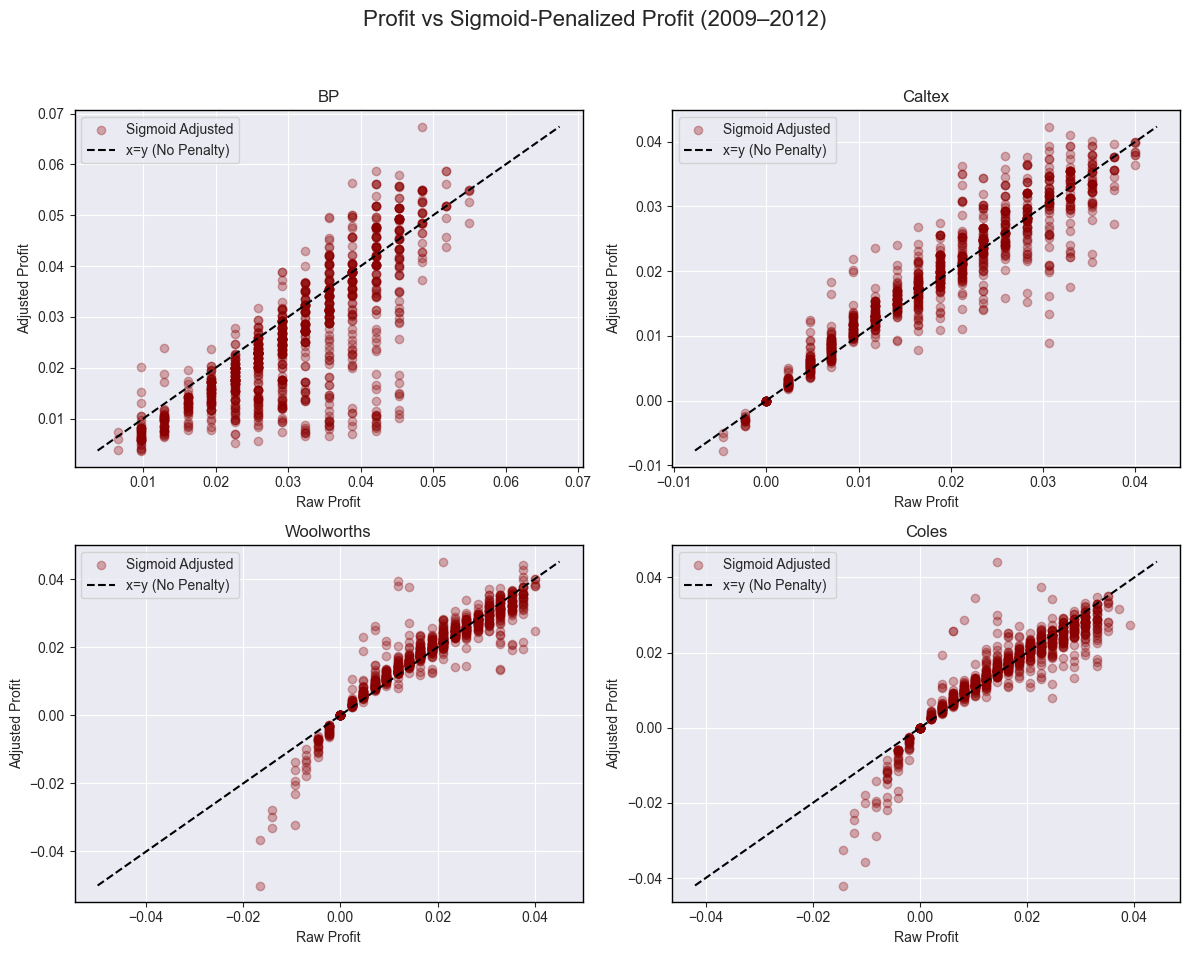

In [14]:
# Define brands to plot
brands_to_plot = ["BP", "Caltex", "Woolworths", "Coles"]

# Create subplots: 2 rows x 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Make it easy to index

for i, brand in enumerate(brands_to_plot):
    ax = axes[i]
    mask = (
        df["brand"] == brand
    )  # & (df['date'] >= start_date) & (df['date'] <= end_date)
    df_b = df.loc[mask].copy()

    ax.scatter(
        df_b["profit"],
        df_b["adjusted_profit_price_deviation"],
        alpha=0.3,
        label="Sigmoid Adjusted",
        color="darkred",
    )
    min_val = min(df_b["profit"].min(), df_b["adjusted_profit_price_deviation"].min())
    max_val = max(df_b["profit"].max(), df_b["adjusted_profit_price_deviation"].max())
    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        color="black",
        linestyle="--",
        label="x=y (No Penalty)",
    )

    ax.set_title(f"{brand}")
    ax.set_xlabel("Raw Profit")
    ax.set_ylabel("Adjusted Profit")
    ax.grid(True)
    ax.legend()

    # Styling
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("black")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

plt.suptitle("Profit vs Sigmoid-Penalized Profit (2009–2012)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

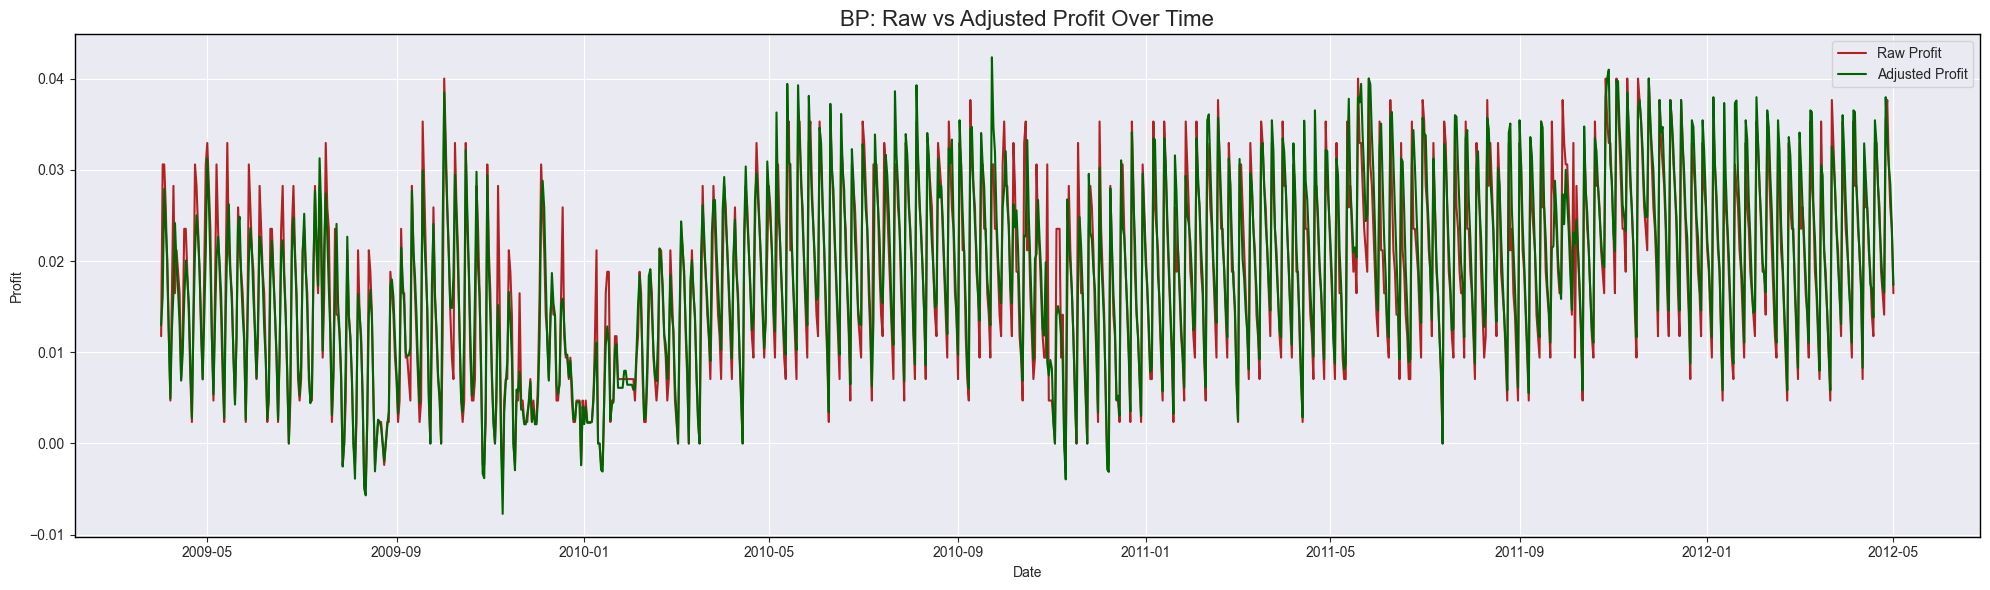

In [18]:
# Filtrar datos solo una vez
mask = df["brand"] == "Caltex"
df_bp = df.loc[mask].copy()
plt.figure(figsize=(20, 6))
sns.lineplot(
    data=df_bp, x="publish_date", y="profit", label="Raw Profit", color="firebrick"
)
sns.lineplot(
    data=df_bp,
    x="publish_date",
    y="adjusted_profit_price_deviation",
    label="Adjusted Profit",
    color="darkgreen",
)
plt.title("BP: Raw vs Adjusted Profit Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.tight_layout()

ax = plt.gca()

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color("black")

ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
plt.show()

# Simple Demand understanding
---

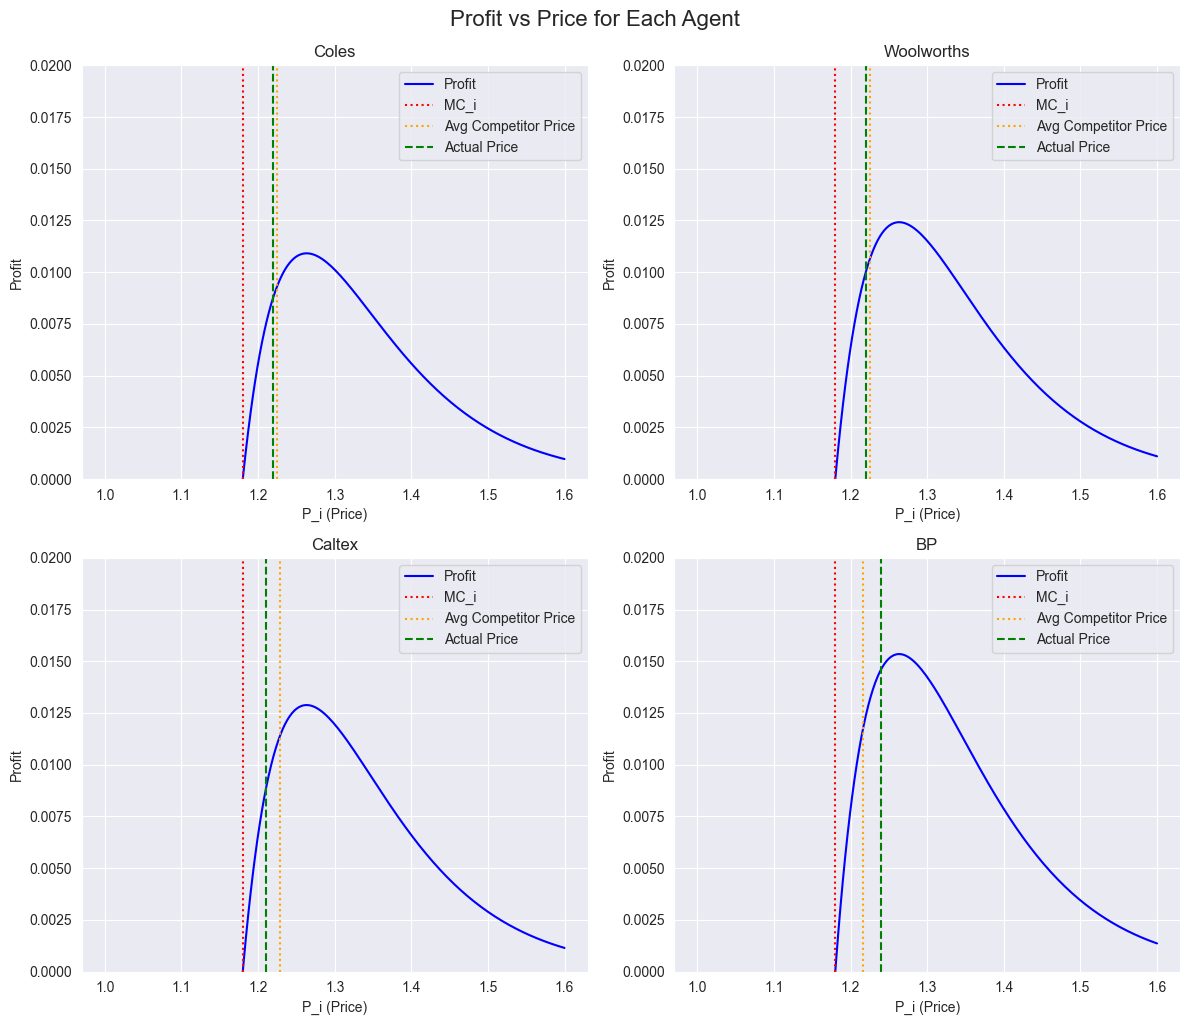

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Agent data. Prices for 2009-04-01
data = [
    {"agent": "Coles", "price": 1.22, "marginal_cost": 1.18, "market_share": 0.207},
    {
        "agent": "Woolworths",
        "price": 1.22,
        "marginal_cost": 1.18,
        "market_share": 0.235,
    },
    {"agent": "Caltex", "price": 1.21, "marginal_cost": 1.18, "market_share": 0.235},
    {"agent": "BP", "price": 1.24, "marginal_cost": 1.18, "market_share": 0.323},
]

LAMBDA = 12  # 15.66  # Penalty parameter
P_i_values = np.linspace(1.0, 1.6, 200)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for idx, agent_data in enumerate(data):
    name = agent_data["agent"]
    P_i_real = agent_data["price"]
    MC_i = agent_data["marginal_cost"]
    S_i = agent_data["market_share"]

    # Exclude current agent
    competitors = [d for j, d in enumerate(data) if j != idx]
    prices_excl_i = np.array([d["price"] for d in competitors])
    weights_excl_i = np.array([d["market_share"] for d in competitors])
    normalized_weights = weights_excl_i / np.sum(weights_excl_i)

    P_avg_weighted_competitors = np.average(prices_excl_i, weights=normalized_weights)

    profits = []
    for P_i in P_i_values:
        price_deviation = P_i - P_avg_weighted_competitors
        penalty = np.exp(-LAMBDA * price_deviation)
        profit = (P_i - MC_i) * S_i * penalty
        profits.append(profit)

    # Plot
    ax = axs[idx]
    ax.plot(P_i_values, profits, label="Profit", color="blue")
    ax.axvline(MC_i, color="red", linestyle=":", label="MC_i")
    ax.axvline(
        P_avg_weighted_competitors,
        color="orange",
        linestyle=":",
        label="Avg Competitor Price",
    )
    ax.axvline(P_i_real, color="green", linestyle="--", label="Actual Price")

    ax.set_title(f"{name}")
    ax.set_xlabel("P_i (Price)")
    ax.set_ylabel("Profit")
    ax.set_ylim(bottom=0, top=0.02)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle("Profit vs Price for Each Agent", fontsize=16, y=1.02)
plt.show()

In [42]:
(1.22 - 1.12) * 0.2058823529411765 * np.exp(-12 * (1.22 - 1.40))

np.float64(0.1785234223801296)

In [40]:
df

,publish_date,brand,avg_price,tgpmin,market_share,avg_comp_price,profit,price_deviation,abs_deviation,adjusted_profit_price_deviation,adjusted_profit_abs_deviation
0,2009-04-01,BP,1.24,1.11,0.323529,1.130435,0.042059,1.095652e-01,1.095652e-01,0.010563,0.061429
1,2009-04-01,Caltex,1.16,1.11,0.235294,1.167692,0.011765,-7.692308e-03,7.692308e-03,0.012963,0.012082
2,2009-04-01,Coles,1.12,1.11,0.205882,1.177778,0.002059,-5.777778e-02,5.777778e-02,0.004266,0.002514
3,2009-04-01,Woolworths,1.11,1.11,0.235294,1.183077,0.000000,-7.307692e-02,7.307692e-02,0.000000,0.000000
4,2009-04-02,BP,1.23,1.11,0.323529,1.187391,0.038824,4.260870e-02,4.260870e-02,0.022685,0.044986
...,...,...,...,...,...,...,...,...,...,...,...
4499,2012-04-30,Woolworths,1.49,1.39,0.235294,1.490000,0.023529,4.440892e-16,4.440892e-16,0.023529,0.023529
4500,2012-05-01,BP,1.48,1.40,0.323529,1.470000,0.025882,1.000000e-02,1.000000e-02,0.022816,0.026793
4501,2012-05-01,Caltex,1.47,1.40,0.235294,1.474231,0.016471,-4.230769e-03,4.230769e-03,0.017373,0.016713
4502,2012-05-01,Coles,1.47,1.40,0.205882,1.474074,0.014412,-4.074074e-03,4.074074e-03,0.015172,0.014616


In [48]:
MARKET_SHARES = np.array([0.22, 0.16, 0.16, 0.14])
normalized_market_shares = MARKET_SHARES / np.sum(MARKET_SHARES)
# round(normalized_market_shares, 3)  # Round to 3 decimal places for clarity
normalized_market_shares = [float(round(x, 4)) for x in normalized_market_shares]
print(normalized_market_shares)

[0.3235, 0.2353, 0.2353, 0.2059]


In [46]:
np.sum(normalized_market_shares)

np.float64(1.0)